In [1]:
# %%
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nilearn import plotting, image

In [2]:
def mosaic(volume, cmap='gray'):
    # Plot each axial slice in a big figure
    fig, axes = plt.subplots(6, 8, figsize=(16, 12))
    for i in range(volume.shape[2]):
        ax = axes[i // 8, i % 8]
        ax.imshow(volume[:, :, i].T, origin='lower', cmap=cmap)
        ax.axis('off')
        ax.set_title(f"z={i}")

    plt.tight_layout()
    plt.show()

In [3]:
roi_dir = '/Users/hugofluhr/phd_local/data/LearningHabits/dev_sample/masks/MNI152NLin2009cAsym'

def load_rois(roi_dir, ref_img = None, bool_data = False):
    files = [f for f in os.listdir(roi_dir) if f.endswith('.nii')]
    roi_names = [f.split('_')[0] for f in files]

    rois = {n: image.load_img(os.path.join(roi_dir, f)) for n, f in zip(roi_names, files)}

    if ref_img is not None:
        rois = {n: image.resample_to_img(img, ref_img, force_resample=True, copy_header=True)
            for n, img in rois.items()}

    if bool_data:
        rois = {n: np.squeeze(img.get_fdata() > 0)
            for n, img in rois.items()}

    return rois

# With SDC

In [4]:
mask_dir = os.path.expanduser('~/phd_local/data/LearningHabits/first_lvl_masks/glm2_combined_2025-10-7-03-57')  # adjust if needed

In [5]:
# === Collect mask files ===
mask_files = sorted([os.path.join(mask_dir, f)
                     for f in os.listdir(mask_dir)
                     if f.endswith('.nii') or f.endswith('.nii.gz')])

print(f"Found {len(mask_files)} masks.")
mask_files[:5]
learning_masks = [m for m in mask_files if 'learning' in m]
test_masks = [m for m in mask_files if 'test' in m]

Found 120 masks.


In [6]:
mask_files[:5]

['/Users/hugofluhr/phd_local/data/LearningHabits/first_lvl_masks/glm2_combined_2025-10-7-03-57/sub-01_learning_mask.nii',
 '/Users/hugofluhr/phd_local/data/LearningHabits/first_lvl_masks/glm2_combined_2025-10-7-03-57/sub-01_test_mask.nii',
 '/Users/hugofluhr/phd_local/data/LearningHabits/first_lvl_masks/glm2_combined_2025-10-7-03-57/sub-02_learning_mask.nii',
 '/Users/hugofluhr/phd_local/data/LearningHabits/first_lvl_masks/glm2_combined_2025-10-7-03-57/sub-02_test_mask.nii',
 '/Users/hugofluhr/phd_local/data/LearningHabits/first_lvl_masks/glm2_combined_2025-10-7-03-57/sub-03_learning_mask.nii']

## Learning Masks

In [7]:
data_learning = np.stack([image.load_img(f).get_fdata().astype(bool) for f in learning_masks], axis=-1)
print(f"Mask shape: {data_learning.shape[:-1]}, N subjects: {data_learning.shape[-1]}")

Mask shape: (53, 65, 48), N subjects: 60


In [8]:
# Already remove sub-54 because it's terrible
#data_learning = np.delete(data_learning, 42, axis=-1)

In [9]:
## === Compute voxelwise coverage ===
coverage = data_learning.mean(axis=-1)
intersection = coverage == 1

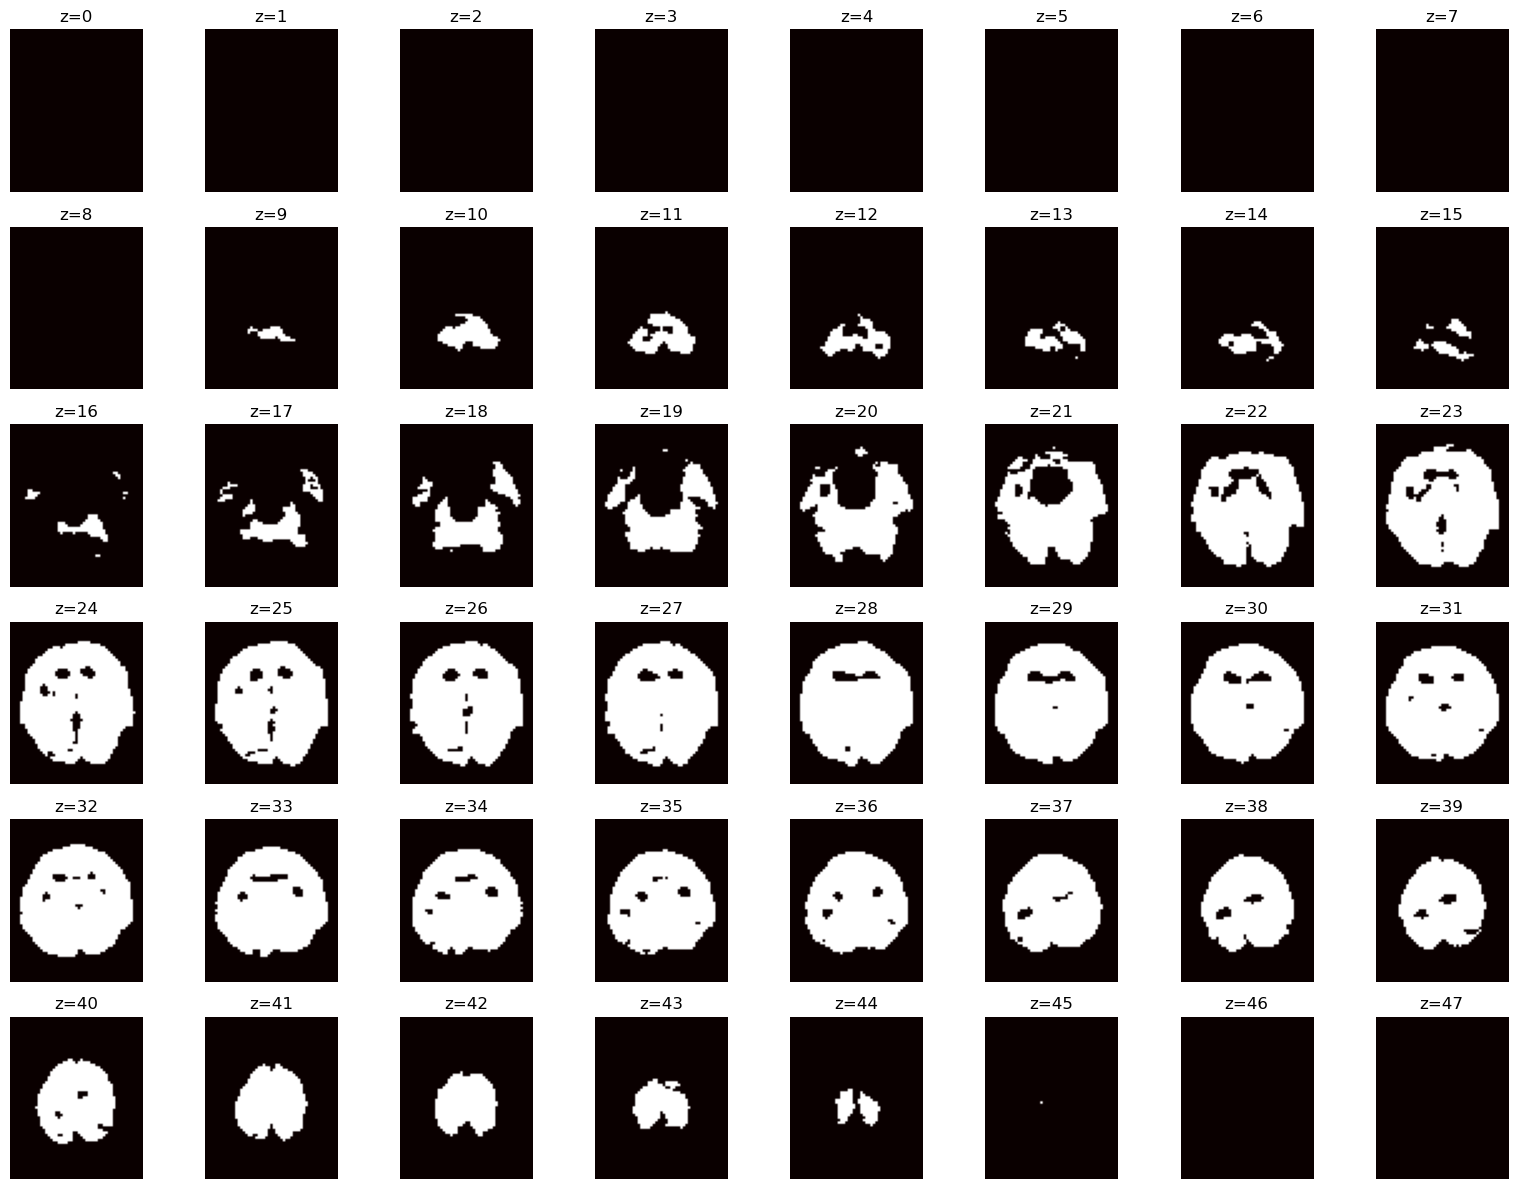

In [10]:
mosaic(intersection.astype(int), cmap='hot')

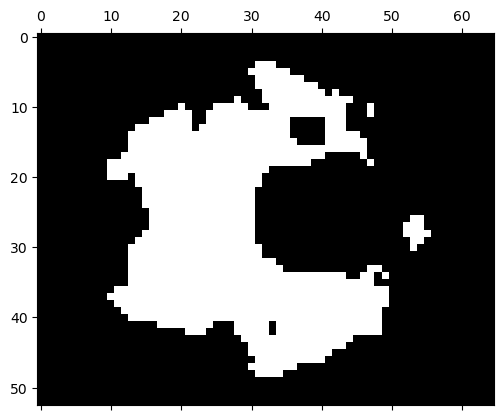

In [11]:
plt.matshow(intersection[...,20], cmap='grey')

In [12]:
# problematic locations:
#x, y, z = 22, 13, 25
#x, y, z = 32, 56, 27
x, y, z = 20, 50, 20
intersection[x,y,z]

np.False_

In [13]:
np.where(data_learning[x,y,z,:]==0)[0]

array([14, 31, 56])

In [14]:
tagged_learning = [7, 14, 22, 31, 55]
print('tagged masks: ')
for i in tagged_learning:
    print(learning_masks[i])

tagged masks: 
/Users/hugofluhr/phd_local/data/LearningHabits/first_lvl_masks/glm2_combined_2025-10-7-03-57/sub-09_learning_mask.nii
/Users/hugofluhr/phd_local/data/LearningHabits/first_lvl_masks/glm2_combined_2025-10-7-03-57/sub-18_learning_mask.nii
/Users/hugofluhr/phd_local/data/LearningHabits/first_lvl_masks/glm2_combined_2025-10-7-03-57/sub-27_learning_mask.nii
/Users/hugofluhr/phd_local/data/LearningHabits/first_lvl_masks/glm2_combined_2025-10-7-03-57/sub-38_learning_mask.nii
/Users/hugofluhr/phd_local/data/LearningHabits/first_lvl_masks/glm2_combined_2025-10-7-03-57/sub-69_learning_mask.nii


In [15]:
new_learning_mask = np.delete(data_learning, tagged_learning, axis=-1).mean(axis=-1) == 1.

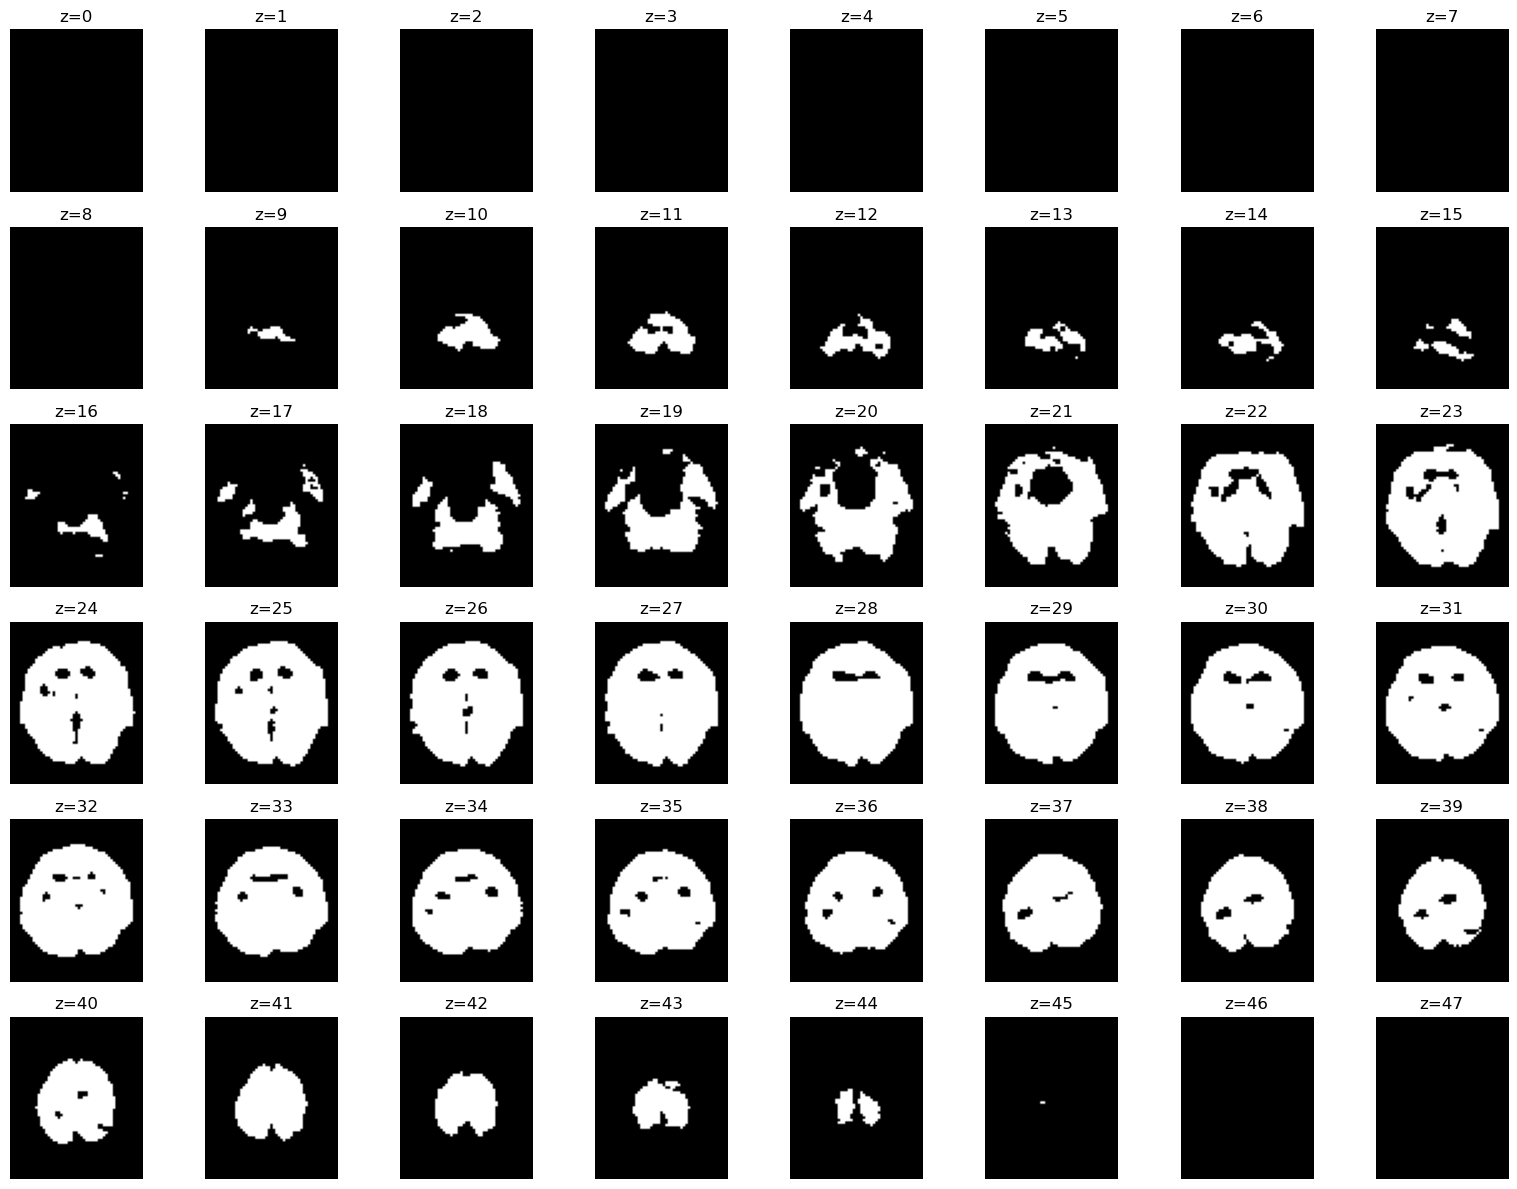

In [16]:
mosaic(new_learning_mask)

### Checking our ROIs

In [17]:
ROIs = load_rois(roi_dir, ref_img=learning_masks[0], bool_data=True)

In [18]:
lenient = coverage >= 0.99

for name, roi in ROIs.items():
    n_voxels = roi.sum()
    roi_coverage = (lenient*roi).sum()
    frac = (roi_coverage / n_voxels) if n_voxels else 0.0
    print(f"{name:<15s} {roi_coverage:6d}/{n_voxels:6d} vox  ({frac*100:6.2f}%)")

striatum            27/   128 vox  ( 21.09%)
habit              522/   657 vox  ( 79.45%)
vmpfc               36/   119 vox  ( 30.25%)
parietal          2366/  2885 vox  ( 82.01%)
motor             5184/  6345 vox  ( 81.70%)


## Test

In [19]:
data_test = np.stack([image.load_img(f).get_fdata().astype(bool) for f in test_masks], axis=-1)
coverage_test = data_test.mean(axis=-1)
intersection_test = coverage_test == 1

In [20]:
lenient_test = coverage_test >= 0.99

for name, roi in ROIs.items():
    n_voxels = roi.sum()
    roi_coverage = (lenient_test*roi).sum()
    frac = (roi_coverage / n_voxels) if n_voxels else 0.0
    print(f"{name:<15s} {roi_coverage:6d}/{n_voxels:6d} vox  ({frac*100:6.2f}%)")

striatum            39/   128 vox  ( 30.47%)
habit              544/   657 vox  ( 82.80%)
vmpfc               59/   119 vox  ( 49.58%)
parietal          2539/  2885 vox  ( 88.01%)
motor             5502/  6345 vox  ( 86.71%)


# With NO SDC

In [21]:
mask_dir = '/Users/hugofluhr/phd_local/data/LearningHabits/first_lvl_masks/noSDC/glm2_combined_2025-11-17-01-52'

In [22]:
# === Collect mask files ===
mask_files_noSDC = sorted([os.path.join(mask_dir, f)
                     for f in os.listdir(mask_dir)
                     if f.endswith('.nii') or f.endswith('.nii.gz')])

print(f"Found {len(mask_files_noSDC)} masks.")
mask_files_noSDC[:5]
learning_masks_noSDC = [m for m in mask_files_noSDC if 'learning' in m]
test_masks_noSDC = [m for m in mask_files_noSDC if 'test' in m]

Found 120 masks.


## Learning Masks

In [23]:
data_learning_noSDC = np.stack([image.load_img(f).get_fdata().astype(bool) for f in learning_masks_noSDC], axis=-1)
coverage_noSDC = data_learning_noSDC.mean(axis=-1)
intersection_noSDC = coverage_noSDC == 1

### Checking ROIs coverage

In [24]:
ROIs = load_rois(roi_dir, ref_img=learning_masks_noSDC[0], bool_data=True)

lenient_noSDC = coverage_noSDC >= 0.95
for name, roi in ROIs.items():
    n_voxels = roi.sum()
    coverage_roi = (lenient_noSDC*roi).sum()
    frac = (coverage_roi / n_voxels) if n_voxels else 0.0
    print(f"{name:<15s} {coverage_roi:6d}/{n_voxels:6d} vox  ({frac*100:6.2f}%)")

striatum           113/   128 vox  ( 88.28%)
habit              651/   657 vox  ( 99.09%)
vmpfc              118/   119 vox  ( 99.16%)
parietal          2667/  2885 vox  ( 92.44%)
motor             5759/  6345 vox  ( 90.76%)


## Test Masks

In [25]:
data_test_noSDC = np.stack([image.load_img(f).get_fdata().astype(bool) for f in test_masks_noSDC], axis=-1)
coverage_test_noSDC = data_test_noSDC.mean(axis=-1)
intersection_test_noSDC = coverage_test_noSDC == 1

### Checking ROIs coverage

In [26]:
ROIs = load_rois(roi_dir, ref_img=test_masks_noSDC[0], bool_data=True)

lenient_test_noSDC = coverage_test_noSDC >= 0.95
for name, roi in ROIs.items():
    n_voxels = roi.sum()
    coverage_roi = (lenient_test_noSDC*roi).sum()
    frac = (coverage_roi / n_voxels) if n_voxels else 0.0
    print(f"{name:<15s} {coverage_roi:6d}/{n_voxels:6d} vox  ({frac*100:6.2f}%)")

striatum           121/   128 vox  ( 94.53%)
habit              653/   657 vox  ( 99.39%)
vmpfc              119/   119 vox  (100.00%)
parietal          2674/  2885 vox  ( 92.69%)
motor             5752/  6345 vox  ( 90.65%)


In [28]:
ROIs = load_rois(roi_dir, ref_img=test_masks_noSDC[0], bool_data=True)

lenient_test_noSDC = coverage_test_noSDC >= 0.95
for name, roi in ROIs.items():
    n_voxels = roi.sum()
    coverage_roi = (lenient_test_noSDC*roi).sum()
    frac = (coverage_roi / n_voxels) if n_voxels else 0.0
    print(f"{name:<15s} {coverage_roi:6d}/{n_voxels:6d} vox  ({frac*100:6.2f}%)")# Per subject coverage

## Finding worst subjects

In [62]:
# Here I'm ranking subjects by their coverage within each ROI
ranking = {}
for name, roi in ROIs.items():
    n_voxels = roi.sum()
    subject_coverage = (data_learning_noSDC * roi[..., np.newaxis]).sum(axis=(0,1,2))
    frac_coverage = subject_coverage / n_voxels
    # sort and get subject id
    sorted_subjects = np.argsort(frac_coverage)
    ranking[name] = (sorted_subjects, frac_coverage[sorted_subjects])

In [65]:
ranking['striatum']

(array([54, 47, 13, 21, 40, 33,  6, 58,  8, 39, 16,  0,  2, 49, 31, 27,  3,
        51, 50, 36, 37, 57, 38, 41, 42, 56, 44, 45, 46, 55, 53, 48, 52, 43,
        35, 29, 32,  1,  4,  5,  7,  9, 10, 11, 12, 14, 15, 17, 18, 19, 20,
        22, 23, 24, 25, 26, 28, 30, 34, 59]),
 array([0.7421875, 0.7734375, 0.859375 , 0.9140625, 0.9453125, 0.9453125,
        0.953125 , 0.9609375, 0.96875  , 0.9765625, 0.9765625, 0.9765625,
        0.9765625, 0.984375 , 0.984375 , 0.984375 , 0.984375 , 0.9921875,
        1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
        1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
        1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
        1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
        1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
        1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
        1.       , 1.       , 1.       , 1.       , 1.      

In [67]:
ranking['motor']

(array([36,  1, 31, 23, 52, 16, 10, 42, 27, 38, 19, 49, 59, 15,  4, 48, 43,
        39,  6, 55, 35, 54, 47, 46,  8, 30, 37, 53, 50, 25, 44,  7, 11, 14,
         2, 40, 12, 17, 41, 24,  5, 51, 57, 34, 20, 26, 28,  0,  9,  3, 18,
        21, 29, 13, 45, 33, 22, 58, 32, 56]),
 array([0.90386131, 0.90449173, 0.91977935, 0.92214342, 0.92592593,
        0.92797478, 0.9322301 , 0.93301812, 0.93475177, 0.93490938,
        0.93506698, 0.93522459, 0.935855  , 0.93758865, 0.93821907,
        0.9393223 , 0.93963751, 0.94042553, 0.94168637, 0.94200158,
        0.9427896 , 0.94342002, 0.94531127, 0.94531127, 0.94562648,
        0.94609929, 0.9462569 , 0.9465721 , 0.9465721 , 0.94672971,
        0.94672971, 0.94688731, 0.94751773, 0.94783294, 0.94877857,
        0.94925138, 0.94940898, 0.94972419, 0.95051221, 0.95051221,
        0.95114263, 0.95177305, 0.95256107, 0.95334909, 0.95524035,
        0.95539795, 0.95618597, 0.95634358, 0.95665879, 0.95760441,
        0.95949567, 0.95981087, 0.9605989 , 0.

In [75]:
for sub in ranking['striatum'][0][:5]:
    print(learning_masks_noSDC[sub])

/Users/hugofluhr/phd_local/data/LearningHabits/first_lvl_masks/noSDC/glm2_combined_2025-11-17-01-52/sub-67_learning_mask.nii
/Users/hugofluhr/phd_local/data/LearningHabits/first_lvl_masks/noSDC/glm2_combined_2025-11-17-01-52/sub-59_learning_mask.nii
/Users/hugofluhr/phd_local/data/LearningHabits/first_lvl_masks/noSDC/glm2_combined_2025-11-17-01-52/sub-16_learning_mask.nii
/Users/hugofluhr/phd_local/data/LearningHabits/first_lvl_masks/noSDC/glm2_combined_2025-11-17-01-52/sub-26_learning_mask.nii
/Users/hugofluhr/phd_local/data/LearningHabits/first_lvl_masks/noSDC/glm2_combined_2025-11-17-01-52/sub-52_learning_mask.nii


## Excluding worst subjects

In [56]:
data_learning_noSDC_lean = data_learning_noSDC.copy()
data_learning_noSDC_lean = np.delete(data_learning_noSDC_lean, ranking['striatum'][:3], axis=-1)

In [58]:
coverage_learning_noSDC_lean = data_learning_noSDC_lean.mean(axis=-1)

In [59]:
lenient_noSDC = coverage_noSDC == 1
for name, roi in ROIs.items():
    n_voxels = roi.sum()
    coverage_roi = (lenient_noSDC*roi).sum()
    frac = (coverage_roi / n_voxels) if n_voxels else 0.0
    print(f"{name:<15s} {coverage_roi:6d}/{n_voxels:6d} vox  ({frac*100:6.2f}%)")

striatum            88/   128 vox  ( 68.75%)
habit              604/   657 vox  ( 91.93%)
vmpfc              115/   119 vox  ( 96.64%)
parietal          2516/  2885 vox  ( 87.21%)
motor             5381/  6345 vox  ( 84.81%)


In [60]:
lenient_learning_noSDC_lean = coverage_learning_noSDC_lean == 1
for name, roi in ROIs.items():
    n_voxels = roi.sum()
    coverage_roi = (lenient_learning_noSDC_lean*roi).sum()
    frac = (coverage_roi / n_voxels) if n_voxels else 0.0
    print(f"{name:<15s} {coverage_roi:6d}/{n_voxels:6d} vox  ({frac*100:6.2f}%)")

striatum           104/   128 vox  ( 81.25%)
habit              611/   657 vox  ( 93.00%)
vmpfc              115/   119 vox  ( 96.64%)
parietal          2520/  2885 vox  ( 87.35%)
motor             5381/  6345 vox  ( 84.81%)


In [33]:
data_test_noSDC_lean = data_test_noSDC.copy()
data_test_noSDC_lean = np.delete(data_test_noSDC_lean, flagged_test_noSDC.subj_idx.values, axis=-1)

In [34]:
coverage_test_noSDC_lean = data_test_noSDC_lean.mean(axis=-1)

In [35]:
lenient_test_noSDC_lean = coverage_test_noSDC_lean == 1
for name, roi in ROIs.items():
    n_voxels = roi.sum()
    coverage_roi = (lenient_test_noSDC_lean*roi).sum()
    frac = (coverage_roi / n_voxels) if n_voxels else 0.0
    print(f"{name:<15s} {coverage_roi:6d}/{n_voxels:6d} vox  ({frac*100:6.2f}%)")

striatum           103/   128 vox  ( 80.47%)
habit              622/   657 vox  ( 94.67%)
vmpfc              114/   119 vox  ( 95.80%)
parietal          2564/  2885 vox  ( 88.87%)
motor             5433/  6345 vox  ( 85.63%)
